# GLOBAL SUPERSTORE DATASET SALES ANALYSIS
By Raju Vaneshwar Nareshwar

## 1. Task 1  <a id='task1'></a>

### Load first 10 records

In [77]:
# pip install packages
!{sys.executable} -m pip install geopandas

# import libraries
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import requests
import geopandas as gpd

from matplotlib import ticker as mtick

# Letting pandas to show max columns
pd.set_option('display.max_columns', None)

'{sys.executable}' is not recognized as an internal or external command,
operable program or batch file.


In [78]:
# Reading CSV file and assigning into a dataframe ss_data
global_super_store_data = pd.read_csv('sample-superstore-2023-T3.csv')

# Set the head to 10 to retrieve the first 10 records
first_10_rows = global_super_store_data.head(n=10)
first_10_rows

,Row ID,Order ID,Order Date,Ship Date,Ship Mode,Customer ID,Customer Name,Segment,Country,City,State,Postal Code,Region,Product ID,Category,Sub-Category,Product Name,Sales,Quantity,Discount,Profit
0,7773,CA-2016-108196,25/11/2016,12/02/2016,Standard Class,CS-12505,Cindy Stewart,Consumer,United States,Lancaster,Ohio,43130,Est,TEC-MA-10000418,Technology,Machines,Cubify CubeX 3D Printer Double Head Print,4499.985,5,0.7,-6599.978
1,684,US-2017-168116,11/04/2017,11/04/2017,Same Day,GT-14635,Grant Thornton,Corporate,United States,Burlington,North Carolina,"""27217""",South,TEC-MA-10004125,Technology,Machines,Cubify CubeX 3D Printer Triple Head Print,7999.980,4,0.5,-3839.9904
2,9775,CA-2014-169019,26/07/2014,30/07/2014,Standard Class,LF-17185,Luke Foster,Consumer,United States,San Antonio,Texas,78207,Central,OFF-BI-10004995,Office Supplies,Binders,GBC DocuBind P400 Electric Binding System,2177.584,8,0.8,-3701.8928
3,3012,CA-2017-134845,17/04/2017,24/04/2017,Standard Class,SR-20425,Sharelle Roach,Home Office,United States,Louisville,Colorado,80027,West,TEC-MA-10000822,Technology,Machines,Lexmark MX611dhe Monochrome Laser Printer,2549.985,5,0.7,-3399.98
4,4992,US-2017-122714,12/07/2017,13/12/2017,Standard Class,HG-14965,Henry Goldwyn,Corporate,United States,Chicago,Illinois,60653,Central,OFF-BI-10001120,Office Supplies,Binders,Ibico EPK-21 Electric Binding System,1889.990,5,0.8,-2929.4845
5,3152,CA-2015-147830,15/12/2015,18/12/2015,First Class,NF-18385,Natalie Fritzler,Consumer,United States,Newark,Ohio,43055,East,TEC-MA-10000418,Technology,Machines,Cubify CubeX 3D Printer Double Head Print,1799.994,Two,0.7,"""-2639.9912"""
6,5311,CA-2017-131254,19/11/2017,21/11/2017,First Class,NC-18415,Nathan Cano,Consumer,United States,Houston,Texas,77095,Central,OFF-BI-10003527,Office Supplies,Binders,Fellowes PB500 Electric Punch Plastic Comb Bin...,1525.188,6,0.8,-2287.782
7,9640,CA-2015-116638,28/01/2015,NaN,Second Class,JH-15985,Joseph Holt,Consumer,United States,Concord,North Carolina,28027,South,FUR-TA-10000198,Frnture,Tables,Chromcraft Bull-Nose Wood Oval Conference Tabl...,4297.644,Thirteen,0.4,NaN
8,1200,CA-2016-130946,04/08/2016,04/12/2016,Standard Class,ZC-21910,Zuschuss Carroll,Consumer,United States,Houston,Texas,77041,Central,OFF-BI-10004995,Office Supplies,Binders,GBC DocuBind P400 Electric Binding System,1088.792,4,0.8,-1850.9464
9,2698,CA-2014-145317,18/03/2014,23/03/2014,Standard Class,SM-20320,Sean Miller,Home Office,NaN,Jacksonville,Florida,32216,Southh,TEC-MA-10002412,Technology,Machines,Cisco TelePresence System EX90 Videoconferenci...,22638.480,6,0.5,-1811.0784


### Understanding of the dataset

Using info() and describe() function to get the descriptive statistics

In [79]:
# Get the metadata information about the dataset
global_super_store_data.info()

# Get descriptive statistics on the dataset
global_super_store_data.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9994 entries, 0 to 9993
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Row ID         9994 non-null   int64  
 1   Order ID       9993 non-null   object 
 2   Order Date     9992 non-null   object 
 3   Ship Date      9991 non-null   object 
 4   Ship Mode      9990 non-null   object 
 5   Customer ID    9994 non-null   object 
 6   Customer Name  9991 non-null   object 
 7   Segment        9991 non-null   object 
 8   Country        9990 non-null   object 
 9   City           9992 non-null   object 
 10  State          9990 non-null   object 
 11  Postal Code    9991 non-null   object 
 12  Region         9991 non-null   object 
 13  Product ID     9992 non-null   object 
 14  Category       9992 non-null   object 
 15  Sub-Category   9990 non-null   object 
 16  Product Name   9991 non-null   object 
 17  Sales          9993 non-null   float64
 18  Quantity

,Row ID,Sales,Discount
count,9994.000000,9993.000000,9991.000000
mean,4997.500000,229.863780,0.156180
std,2885.163629,623.276019,0.206399
min,1.000000,0.444000,0.000000
25%,2499.250000,17.280000,0.000000
50%,4997.500000,54.480000,0.200000
75%,7495.750000,209.940000,0.200000
max,9994.000000,22638.480000,0.800000


The primary key of these records are a system-generated, and denoted as column: *RowID*

The datatypes of the dataset are following:
* int64(1)
* float64(2)
* object(18)

A few records of *Quantity* and *Profit* columns has the datatype of object, but it must be float64, thus needs to be cleansed or transformed.  
*Ship Date* and *Order Date* columns are represented as strings, those needs to be converted as datetime.

Once cleansed, the descriptive statistics can be applied to the numerial columns, and they are Sales, Quantity, Discount and Profit.


function **text2float()** will take a txt number as a parameter and convert back to float64 number.

In [80]:
def text2float(textnum, numwords={}):
    try:
        # Attempt to convert to float
        return float(textnum)
    except ValueError:
        # If conversion to float fails, continue with text to number conversion
        textnum = textnum.lower()
        
        if not numwords:
            units = [
                "zero", "one", "two", "three", "four", "five", "six", "seven", "eight",
                "nine", "ten", "eleven", "twelve", "thirteen", "fourteen", "fifteen",
                "sixteen", "seventeen", "eighteen", "nineteen",
            ]

            tens = ["", "", "twenty", "thirty", "forty", "fifty", "sixty", "seventy", "eighty", "ninety"]

            scales = ["hundred", "thousand", "million", "billion", "trillion"]

            numwords["and"] = (1, 0)
            for idx, word in enumerate(units):
                numwords[word] = (1, idx)
            for idx, word in enumerate(tens):
                numwords[word] = (1, idx * 10)
            for idx, word in enumerate(scales):
                numwords[word] = (10 ** (idx * 3 or 2), 0)

        current = result = 0
        for word in textnum.split():
            if word not in numwords:
                raise Exception("Illegal word: " + word)

            scale, increment = numwords[word]
            current = current * scale + increment
            if scale > 100:
                result += current
                current = 0

        return result + current

In [81]:
def get_city_from_postal_code(postal_code):
    if postal_code == '':
        return None

    url = f"http://api.zippopotam.us/us/{postal_code}"
    response = requests.get(url)
    if response.status_code == 200:
        data = response.json()
        city = data['places'][0]['place name']
        return city
    else:
        return None

In [82]:
def get_state_from_postal_code(postal_code):
    if postal_code == '':
        return None

    url = f"http://api.zippopotam.us/us/{postal_code}"
    response = requests.get(url)
    if response.status_code == 200:
        data = response.json()
        state = data['places'][0]['state']
        return state
    else:
        return None

## 2. Task 2

### Handling missing values in the dataset

Before performing any statistical analysis, the numerical column data has to be cleansed to be meaningful.
* Records with special characters on *Quantity* and needs to be cleansed. 
* Records with special characters on *Profit* and needs to be cleansed. 
* Applying the **text2float()** function to fix *Quantity* column. 

In [83]:
# Row ID is not needed for the analysis, hence dropping the column
if 'Row ID' in global_super_store_data.columns:
    global_super_store_data.drop('Row ID', axis=1, inplace=True)

In [84]:
# Removing "?" from Quantity column
global_super_store_data['Quantity'] = global_super_store_data['Quantity'].str.replace('?', '')

# Removing """ from Profit column
global_super_store_data['Profit'] = global_super_store_data['Profit'].str.replace('"', '')

# Assuming zero values for NaN on Profits
global_super_store_data['Profit'] = global_super_store_data['Profit'].fillna(0)

# Removing """ from Postal Code column
global_super_store_data['Postal Code'] = global_super_store_data['Postal Code'].str.replace('"', '')

# Make all records as Country = United States
global_super_store_data['Country'] = 'United States'

# Correcting spelling mistakes on Category column
global_super_store_data['Category'] = global_super_store_data['Category'].replace('Frnture', 'Furniture')

# Filling values on empty Category/Sub-Category records
global_super_store_data['Category'] = global_super_store_data['Category'].fillna('NO_CATEGORY')
global_super_store_data['Sub-Category'] = global_super_store_data['Sub-Category'].fillna('NO_SUB_CATEGORY')

# Datafix on Category based on subcategories
# Apply the condition element-wise
condition = (global_super_store_data['Category'] == 'NO_CATEGORY') & \
            (global_super_store_data['Sub-Category'].isin(['Binders', 'Storage']))

# Update 'Category' where the condition is True
global_super_store_data.loc[condition, 'Category'] = 'Office Supplies'


In [85]:
# Cleanse the Regions
central_regions_to_replace = ['Centrl', 'Cntral']
east_regions_to_replace = ['Est']
south_regions_to_replace = ['Southh']

global_super_store_data['Region'] = global_super_store_data['Region'].replace(central_regions_to_replace, 'Central')
global_super_store_data['Region'] = global_super_store_data['Region'].replace(east_regions_to_replace, 'East')
global_super_store_data['Region'] = global_super_store_data['Region'].replace(south_regions_to_replace, 'South')

In [86]:
# Applying get_state_from_postal_code function

# Filter the empty state rows
state_filtered_na = global_super_store_data.loc[pd.isna(global_super_store_data['State'])]
state_filtered_na

# Apply the function to fill the missing value via API
global_super_store_data.loc[pd.isna(global_super_store_data['State']), 'State'] = state_filtered_na['Postal Code'].apply(get_state_from_postal_code)

In [87]:
# Applying get_city_from_postal_code function

# Filter the empty city rows
city_filtered_na = global_super_store_data.loc[pd.isna(global_super_store_data['City'])]
city_filtered_na

# Apply the function to fill the missing value via API
global_super_store_data.loc[pd.isna(global_super_store_data['City']), 'City'] = city_filtered_na['Postal Code'].apply(get_city_from_postal_code)

In [88]:
# Applying text2float function
global_super_store_data['Quantity'] = global_super_store_data['Quantity'].apply(text2float)
global_super_store_data['Profit'] = global_super_store_data['Profit'].apply(text2float)

### Descriptive Statistics

In [89]:
global_super_store_data.describe()

,Sales,Quantity,Discount,Profit
count,9993.000000,9989.000000,9991.000000,9994.000000
mean,229.863780,3.789368,0.156180,29.048651
std,623.276019,2.225495,0.206399,233.095599
min,0.444000,1.000000,0.000000,-6599.978000
25%,17.280000,2.000000,0.000000,1.728750
50%,54.480000,3.000000,0.200000,8.666500
75%,209.940000,5.000000,0.200000,29.364000
max,22638.480000,14.000000,0.800000,8399.976000


In [90]:
# Columns with missing data
print(f"Sum of null records:\n{global_super_store_data.isnull().sum()}")

Sum of null records:
Order ID         1
Order Date       2
Ship Date        3
Ship Mode        4
Customer ID      0
Customer Name    3
Segment          3
Country          0
City             0
State            0
Postal Code      3
Region           3
Product ID       2
Category         0
Sub-Category     0
Product Name     3
Sales            1
Quantity         5
Discount         3
Profit           0
dtype: int64


### Grouping of data

#### Grouping Sales/Profits based on Categories

In [91]:
unique_categories = global_super_store_data['Category'].unique()
print(unique_categories)

['Technology' 'Office Supplies' 'Furniture']


In [92]:
# group total sales by category from the highest sale.
sales_category = global_super_store_data.groupby('Category')['Sales'].sum().sort_values(ascending=False)
sales_category

Category
Technology         836154.0330
Furniture          741827.6853
Office Supplies    719047.0320
Name: Sales, dtype: float64

In [93]:
# group total profits by category
profit_category = global_super_store_data.groupby('Category')['Profit'].sum().sort_values(ascending=False)
profit_category

Category
Technology         145482.6639
Office Supplies    123883.7839
Furniture           20945.7713
Name: Profit, dtype: float64

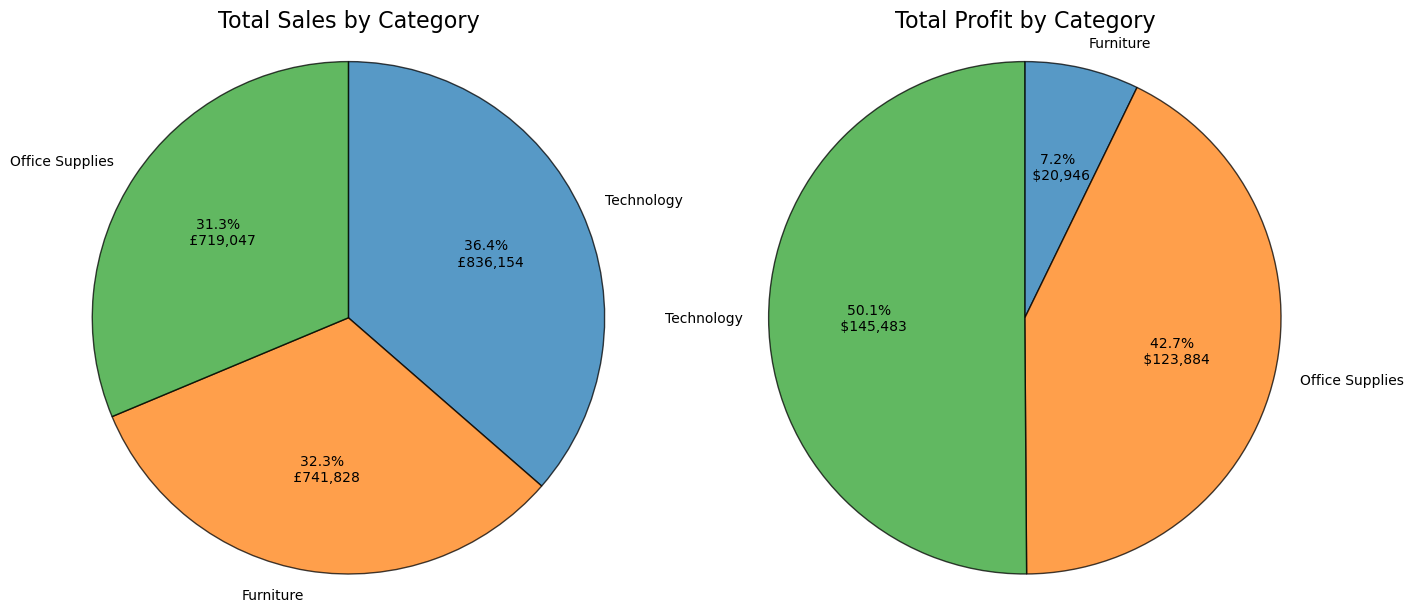

In [94]:
# group total sales by category, only considering positive sales
sales_based_on_category = global_super_store_data.groupby('Category').filter(lambda x: x['Sales'].sum() > 0).groupby('Category')['Sales'].sum()

# group total profit by category, only considering positive profits
profit_category = global_super_store_data.groupby('Category').filter(lambda x: x['Profit'].sum() > 0).groupby('Category')['Profit'].sum()

# figure size
plt.figure(figsize=(16,12));

# left total sales pie chart
plt.subplot(1,2,1); # 1 row, 2 columns, the 1st plot.
plt.pie(sales_category.values, labels=sales_category.index, startangle=90, counterclock=False,
        autopct=lambda p:f'{p:.1f}% \n £{p*np.sum(sales_category.values)/100 :,.0f}', 
        wedgeprops={'linewidth': 1, 'edgecolor':'black', 'alpha':0.75});
plt.axis('square');
plt.title('Total Sales by Category',  fontdict={'fontsize':16});

# right total profits pie chart
plt.subplot(1,2,2); # 1 row, 2 columns, the 2nd plot
plt.pie(profit_category.values, labels=profit_category.index, startangle=90, counterclock=False,
        autopct=lambda p:f'{p:.1f}% \n ${p*np.sum(profit_category.values)/100 :,.0f}',
        wedgeprops={'linewidth': 1, 'edgecolor':'black', 'alpha':0.75});
plt.axis('square');
plt.title('Total Profit by Category', fontdict={'fontsize':16});

 > _Total Sales on Categories_

1. Technology at 36.4% 
2. Furniture at 32.3%
3. Office Supplies at 31.3%

Sales depict a near-perfect symmmetery on categories, with **Technology** winning with a slight edge.

 > _Total Profits on Categories_

1. Technology at 50.1%
2. Office Supplies at 42.7%
3. Furniture at 7.2%

Profits are largely taken by **Technology** category with *Office Supplies* being the lowest.

#### Grouping Sales/Profits based on Sub-Categories

In [95]:
unique_sub_categories = global_super_store_data['Sub-Category'].unique()
unique_sub_categories

array(['Machines', 'Binders', 'Tables', 'Bookcases', 'NO_SUB_CATEGORY',
       'Appliances', 'Supplies', 'Chairs', 'Furnishings', 'Phones',
       'Storage', 'Accessories', 'Fasteners', 'Art', 'Envelopes',
       'Labels', 'Paper', 'Copiers'], dtype=object)

In [96]:
# group total sales by sub-category from the highest sale.
sales_sub_category = global_super_store_data.groupby(['Sub-Category'], as_index=False)['Sales'].sum().sort_values(by='Sales', ascending=False)
sales_sub_category

,Sub-Category,Sales
14,Phones,330007.0540
5,Chairs,328449.1030
15,Storage,223570.8720
17,Tables,206191.9520
3,Binders,202515.7430
11,Machines,189058.6400
0,Accessories,167380.3180
6,Copiers,149528.0300
4,Bookcases,114879.9963
1,Appliances,107532.1610


In [97]:
# group total profit by sub-category from the highest profit.
profit_sub_category = global_super_store_data.groupby(['Sub-Category'], as_index=False)['Profit'].sum().sort_values(by='Sub-Category')
profit_sub_category

,Sub-Category,Profit
0,Accessories,41936.6357
1,Appliances,18190.9638
2,Art,6527.7870
3,Binders,32959.8093
4,Bookcases,-2988.0392
5,Chairs,26653.5428
6,Copiers,55617.8249
7,Envelopes,6964.1767
8,Fasteners,949.5182
9,Furnishings,13143.4364


In [98]:
#Grouping the data on category and it's respective sub-categories. Calculating the profit margin.
sales_per_cat_subcat = global_super_store_data.groupby(['Category', 'Sub-Category'], as_index=False)[['Sales', 'Profit']].sum()
sales_per_cat_subcat['Profit Margin %'] = (sales_per_cat_subcat['Profit'] / sales_per_cat_subcat['Sales']) * 100

#Sorting the dataframe based on profit margin
sales_per_cat_subcat = sales_per_cat_subcat.sort_values(by=['Profit Margin %'], ascending=False)
sales_per_cat_subcat

,Category,Sub-Category,Sales,Profit,Profit Margin %
10,Office Supplies,Labels,12486.3120,5546.2540,44.418672
12,Office Supplies,Paper,78479.2060,34053.5693,43.391837
8,Office Supplies,Envelopes,16476.4020,6964.1767,42.267582
16,Technology,Copiers,149528.0300,55617.8249,37.195585
9,Office Supplies,Fasteners,3024.2800,949.5182,31.396504
15,Technology,Accessories,167380.3180,41936.6357,25.054700
6,Office Supplies,Art,27118.7920,6527.7870,24.071083
5,Office Supplies,Appliances,107532.1610,18190.9638,16.916766
7,Office Supplies,Binders,202515.7430,32959.8093,16.275184
2,Furniture,Furnishings,91705.1640,13143.4364,14.332275


#### Grouping Sales/Profits based on States

In [99]:
# group total sales by states from the highest sale.
sales_by_states = global_super_store_data.groupby(['State'], as_index=False)['Sales'].sum().sort_values(by='Sales', ascending=False)
sales_by_states['Sales %'] = (sales_by_states['Sales'] / global_super_store_data['Sales'].sum()) * 100
print(sales_by_states.describe())
sales_by_states

               Sales    Sales %
count      49.000000  49.000000
mean    46878.137761   2.040816
std     80774.905475   3.516495
min       919.910000   0.040048
25%      7464.930000   0.324982
50%     22205.150000   0.966690
75%     49095.840000   2.137363
max    457687.631500  19.925203


,State,Sales,Sales %
3,California,457687.6315,19.925203
30,New York,310876.2710,13.533843
41,Texas,170188.0458,7.409052
45,Washington,138641.2700,6.035678
36,Pennsylvania,116511.9140,5.072288
8,Florida,89473.7080,3.895193
11,Illinois,80166.1010,3.489991
33,Ohio,78086.0260,3.399436
20,Michigan,76269.6140,3.320360
44,Virginia,70636.7200,3.075134


> **State which made the highest sales:** California
> 
> **State which made the lowest sales:** North Dakota

#### Grouping Sales/Profits based on Segment

In [101]:
# group total sales by segments from the highest sale.
sales_by_segment = global_super_store_data.groupby(['Segment'], as_index=False)['Sales'].sum().sort_values(by='Sales', ascending=False)
sales_by_segment['Sales %'] = (sales_by_segment['Sales'] / global_super_store_data['Sales'].sum()) * 100
sales_by_segment

,Segment,Sales,Sales %
1,Consumer,1.160093e+06,50.504086
2,Corporate,7.057468e+05,30.724336
3,Home Office,4.295764e+05,18.701393
0,%,3.995400e+02,0.017394


**Consumer** Segment has 50% of Sales share, followed by **Corporate** and **Home Office**.

#### Grouping Sales/Profits based on Shipping Mode

In [106]:
# group total sales by segments from the highest sale.
sales_by_ship_mode = global_super_store_data.groupby(['Ship Mode'], as_index=False)['Sales'].sum().sort_values(by='Sales', ascending=False)
sales_by_ship_mode['Sales %'] = (sales_by_ship_mode['Sales'] / global_super_store_data['Sales'].sum()) * 100
sales_by_ship_mode

,Ship Mode,Sales,Sales %
3,Standard Class,1.357094e+06,59.080412
2,Second Class,4.589246e+05,19.979055
0,First Class,3.514284e+05,15.299261
1,Same Day,1.283631e+05,5.588225


**Standard** shipping method is preferred as the sales percentage is nearly 60%, followed by **Second Class** and **First Class**. 
**Same Day** is not an economical option, so only preferred by 5% of the orders.

In [138]:

# global_super_store_data['Order Date'] = global_super_store_data['Order Date'].str.replace('$April', '15/04/2015')
# global_super_store_data['Order Date'] = pd.to_datetime(global_super_store_data['Order Date'])
# global_super_store_data['Ship Date'] = pd.to_datetime(global_super_store_data['Ship Date'], format='mixed')
global_super_store_data['Days Between Order/Shipped'] = (global_super_store_data['Ship Date'] - global_super_store_data['Order Date']).dt.days

sales_by_ship_mode_days = global_super_store_data.groupby(['Ship Mode'], as_index=False)['Days Between Order/Shipped'].sum().sort_values(by='Days Between Order/Shipped', ascending=False)
sales_by_ship_mode_days



,Ship Mode,Days Between Order/Shipped
3,Standard Class,132941.0
2,Second Class,46965.0
0,First Class,36530.0
1,Same Day,10238.0


### Univariate analysis and visualisation

#### Profit Margin by Sub-categories

In [ ]:
#Grouping the data on category and it's respective sub-categories. Calculating the profit margin.
sales_per_cat_subcat = global_super_store_data.groupby(['Category', 'Sub-Category'], as_index=False)[['Sales', 'Profit']].sum()
sales_per_cat_subcat['Profit Margin'] = sales_per_cat_subcat['Profit'] / sales_per_cat_subcat['Sales']

#Sorting the dataframe based on profit margin
sales_per_cat_subcat = sales_per_cat_subcat.sort_values(by=['Category', 'Sub-Category', 'Profit Margin'], ascending=True)

# plot a profit margins sub-category bar chart 
fig, ax = plt.subplots(figsize=(14,10))

# Unique sub categories without NO_SUB_CATEGORY
unique_sub_categories_without_custom_label = sales_per_cat_subcat[sales_per_cat_subcat['Sub-Category'] != 'NO_SUB_CATEGORY']['Sub-Category'].unique()

#Plotting the profit margin per sub-category.
sns.barplot(y=sales_per_cat_subcat['Sub-Category'], x=sales_per_cat_subcat['Profit Margin'], hue=sales_per_cat_subcat['Category'], 
                alpha=1, dodge=False, ax=ax, order=unique_sub_categories_without_custom_label)

#Cleaning out bar junk
ax.spines['left'].set_position('zero')
ax.spines[['right','top']].set_visible(False)
ax.set(ylabel=None, xlabel='Profit Margin (%)')

def move_ylabel_tick(index: list):
    """
    Moving the provided ylabel ticks
    """
    for tick in index:
        ax.get_yticklabels()[tick].set_x(0.02)
        ax.get_yticklabels()[tick].set_horizontalalignment('right')

#Moving the y-labels on sub-categories that are making a loss in order to prevent collision of the bar and the text.
move_ylabel_tick([-1, -2, -3])

#Annotating the profit margin amount for each bar.
for p in ax.patches:
    _, y = p.get_xy()
    
    ax.annotate(f'{p.get_width()*100 :.1f}%', (p.get_width() / 2, y + 0.45))
    
#Calculating Superstore's aggregate profit margin in order to compare it to each sub-category's profit margin
mean_profit = sales_per_cat_subcat['Profit'].sum() / sales_per_cat_subcat['Sales'].sum()

#Plotting a vertical line and annotating the Superstore's aggregate profit margin.
ax.axvline(mean_profit, color='blue', label='Mean Profit, All Categories', alpha=0.75, ls='-.')

#Setting the title and legend.
ax.set_title('Profit Margin by Sub-Category', fontdict={'fontsize':16})
ax.legend(loc=(1, 0.9))

#Formatting the x-axis as %
ax.xaxis.set_major_formatter(mtick.PercentFormatter(1.0))

#### Geo Analysis

In [ ]:
base_folder_path = os.getcwd()
shp_path = '/data/usa-states-census-2014.shp'

states = gpd.read_file(f'{base_folder_path}{shp_path}')
states = states.to_crs("EPSG:3395")

# Group data based on States
sales_per_states = global_super_store_data.groupby(['State'], as_index=False)[['Sales']].sum()

# Create a new column to see the Sales %
sales_per_states['Sales %'] = (sales_per_states['Sales'] / global_super_store_data['Sales'].sum()) * 100

# Merge sales data with the US map based on state codes or names
merged_data = states.merge(sales_per_states, how='left', left_on='NAME', right_on='State')

# Plot the map
fig, ax = plt.subplots(1, 1, figsize=(12, 12))
states.plot(ax=ax, color='lightgrey', edgecolor='black')
merged_data.plot(column='Sales %', cmap='Spectral', linewidth=0.8, ax=ax, edgecolor='0.8', legend=True, aspect='equal')
ax.axis('off')
ax.set_title('Sales by US State', loc='center', fontsize=14, y=1.0)
plt.show()

#### Time series analysis

### Correlation 

In [ ]:
#Select Numerical Features
numerical_features = ['Sales', 'Quantity', 'Discount', 'Profit']
global_super_store_numerial_data = global_super_store_data[numerical_features]

correlation_matrix = global_super_store_numerial_data.corr()
correlation_matrix

import seaborn as sns
import matplotlib.pyplot as plt

# Plot correlation matrix as heatmap
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
plt.show()


#### Outlier Treatment

##### Interquartile Range (IQR) Method

In [ ]:
numerical_features = ['Sales', 'Quantity', 'Discount', 'Profit']

for numerical_feature in numerical_features:
    q1 = global_super_store_data[numerical_feature].quantile(0.25)
    q3 = global_super_store_data[numerical_feature].quantile(0.75)
    
    iqr = q3 - q1
    
    lower_limit = q1 - 1.5 * iqr
    upper_limit = q3 + 1.5* iqr

    outliers_df = global_super_store_data[(global_super_store_data[numerical_feature] < lower_limit)|(global_super_store_data[numerical_feature] > upper_limit)]
    sns.boxplot(outliers_df)
    print(f"Outlier numerical feature: {numerical_feature}, Outlier Count: {outliers_df[numerical_feature].count()}")